In [1]:
import pandas as pd
import torch
import tqdm
import numpy as np
from tqdm import tqdm


c:\Users\tsale\OneDrive\Desktop\CS Masters Degree\Recommendation Systems\Project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load train dataset and produce train embeddings
model_name = "cb2cf_multi_modal_encoder_model.pt"
train_data = torch.load("cb2cf_train_dataset.pt")
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=0)
model = torch.load(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    train_embeddings = []
    train_titles = []
    train_movie_ids = []
    for data in tqdm(train_dataloader):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        train_embeddings.append(output.cpu().squeeze().numpy())
        train_titles.append(data["title"])
        train_movie_ids.append(data["movie_ids"])

100%|██████████| 8911/8911 [01:25<00:00, 104.15it/s]


In [3]:
test_data = torch.load("cb2cf_test_dataset.pt")
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

with torch.no_grad():
    test_embeddings = []
    test_titles = []
    test_movie_ids = []
    for i, data in enumerate(tqdm(test_dataloader)):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        test_embeddings.append(output.cpu().squeeze().numpy())
        test_titles.append(data["title"])
        test_movie_ids.append(data["movie_ids"])

100%|██████████| 991/991 [00:09<00:00, 105.87it/s]


In [4]:
oracle_item_embeddings = pd.read_pickle(r"BPR1_item_embeddings.pkl")

# convert train_movie ids and test movie ids to list of integers

train_movie_ids = [int(movie_id) for movie_id in train_movie_ids]
test_movie_ids = [int(movie_id) for movie_id in test_movie_ids]

oracle_train_item_embeddings = oracle_item_embeddings[train_movie_ids]
oracle_test_item_embeddings = oracle_item_embeddings[test_movie_ids]
# all ids 
all_movie_ids = train_movie_ids + test_movie_ids
# all titles
all_titles = train_titles + test_titles
# create a mapping from movie id to title
movie_id_to_title = {movie_id: title for movie_id, title in zip(all_movie_ids, all_titles)}
# all oracle embeddings
all_oracle_embeddings = np.concatenate((oracle_train_item_embeddings, oracle_test_item_embeddings), axis=0)

In [5]:
# Create a dataframe with item id, title, oracle embedding, cb2cf embedding

import pandas as pd
import pickle

df = pd.DataFrame()

oracle_item_embeddings = pd.read_pickle(r"BPR1_item_embeddings.pkl")


df["item_id"] = all_movie_ids
df["title"] = all_titles

df["oracle_embedding"] = list(all_oracle_embeddings)

df["cb2cf_embedding"] = list(train_embeddings + test_embeddings)
# print the first 5 rows of the dataframe

df.head()

# save the dataframe to a pickle file with highest protocol

df.to_pickle("cb2cf_embeddings_and_oracle_embeddings.pkl", protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# load cb2cf_embeddings_and_oracle_embeddings.pkl into a dataframe
cb2cf_embeddings_and_oracle_embeddings_df= pd.read_pickle(r"cb2cf_embeddings_and_oracle_embeddings.pkl")

# print the first 5 rows of the dataframe

cb2cf_embeddings_and_oracle_embeddings_df.head()

,item_id,title,oracle_embedding,cb2cf_embedding
0,1,[Toy Story],"[0.07483365, -0.80597216, -2.5122287, 0.172594...","[0.7114382, 0.20333348, 0.5329094, 0.94893163,..."
1,2,[Jumanji],"[-0.7013331, -0.358848, -0.35755172, 0.3665048...","[-0.19589086, -0.75600845, -0.20841327, 0.9568..."
2,4,[Waiting to Exhale],"[-1.4799722, 0.0777297, -0.37370113, 1.1802115...","[-0.65252167, -1.2592509, -0.67503864, 1.04062..."
3,5,[Father of the Bride Part II],"[-1.7130021, 0.64792114, -0.45365041, 1.244741...","[-0.5138638, -1.3205254, -0.35981533, 1.049852..."
4,6,[Heat],"[-1.9372973, 0.86165136, -0.5711593, 1.8253926...","[-1.9371253, 0.18546836, -0.46241716, 0.865678..."


In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def print_most_similar_movie_titles(relevant_title, relevant_embedding, all_embeddings, all_titles, index_to_ignore=0, n=4):
    all_titles = np.array(all_titles)
    # remove index to ignore from all embeddings and all titles
    all_embeddings = np.delete(all_embeddings, index_to_ignore, axis=0)
    all_titles = np.delete(all_titles, index_to_ignore, axis=0)
    # compute cosine similarity between relevant embedding and all embeddings
    similarities = cosine_similarity(relevant_embedding.reshape(1, -1), all_embeddings)
    # get the indices of the most similar embeddings
    most_similar_indices = np.argsort(similarities[0])[-(n):]
    # remove the first index as it is the relevant embedding itself
    most_similar_indices = most_similar_indices
    # convert to list of integers
    most_similar_indices = most_similar_indices.tolist()
    # convert all titles to numpy array
    titles= all_titles[most_similar_indices]
    print(f"Most similar movies to {relevant_title} are:\n {titles}")
    

In [8]:
# pick a random index from test set
random_index = np.random.randint(0, len(test_embeddings))
# get the relevant title
relevant_title = test_titles[random_index]
# get the relevant embedding from the test set
relevant_embedding = test_embeddings[random_index]
# get the relevant embedding from the oracle set
relevant_oracle_embedding = oracle_test_item_embeddings[random_index]

index_to_ignore = random_index + len(train_embeddings)

# get the most similar movies from the test set
print("Most similar movies from the test set using CB2CF embeddings")
print_most_similar_movie_titles(relevant_title, relevant_embedding, train_embeddings + test_embeddings, train_titles + test_titles, index_to_ignore=index_to_ignore)
# get the most similar movies from the oracle set
print("\n")
print("Most similar movies from the test set using Oracle embeddings")
print_most_similar_movie_titles(relevant_title, relevant_oracle_embedding, all_oracle_embeddings, train_titles + test_titles, index_to_ignore=index_to_ignore)




Most similar movies from the test set using CB2CF embeddings
Most similar movies to ['Stage Door'] are:
 [['Daddy-Long-Legs']
 ['Nothing Sacred']
 ['The Ghost and Mrs. Muir']
 ['Pride and Prejudice']]


Most similar movies from the test set using Oracle embeddings
Most similar movies to ['Stage Door'] are:
 [['The Awful Truth']
 ['Camille']
 ['Jezebel']
 ['Dinner at Eight']]


In [9]:

train_ratings_df= pd.read_pickle(r"beforelastXRatings.pkl",  compression= 'gzip')

# print the first 5 rows of the dataframe


# drop ratings which are 0s

train_ratings_df = train_ratings_df[train_ratings_df["rating"] != 0]

train_ratings_df.head()

,userId,movieId,rating,timestamp
59,4,223,1,1042668576
60,4,415,1,1042667925
61,4,648,1,1042674800
62,4,1097,1,1042667925
63,4,1197,1,1042667956


In [10]:
# Create a tokenizer
from Tokenizer import Tokenizer
import pickle

user_ids = train_ratings_df["userId"].unique().tolist()
print(f"Number of users: {len(user_ids)}")

tokenizer = Tokenizer(item_ids= all_movie_ids, user_ids= user_ids)

# save the tokenizer to a pickle file with highest protocol

with open("tokenizer_next_item_pred_transformer.pkl", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

Number of users: 127878


In [11]:
# check if item with id 144606 is present in train_ratings_df

144606 in train_ratings_df["movieId"].unique()

# check if item with id 144606 is present in all_movie_ids

# This is a bad movie id and should not be present in the train_ratings_df
144606 in all_movie_ids

# print number of unique items in train_ratings_df

print(len(train_ratings_df["movieId"].unique()))

# print number of unique items in all_movie_ids

print(len(all_movie_ids))

# get missing items in train_ratings_df

missing_items = set(train_ratings_df["movieId"].unique()) - set(all_movie_ids)

# remove the missing items from train_ratings_df

train_ratings_df = train_ratings_df[~train_ratings_df["movieId"].isin(missing_items)]

# print the new number of unique items in train_ratings_df

print(len(train_ratings_df["movieId"].unique()))

9903
9902
9902


In [12]:
max_rating_sequence_length = 50

# apply tokenizer_encode_item_ids to the movie ids column
user_id_to_movie_ids = train_ratings_df.groupby("userId")["movieId"].apply(list).apply(tokenizer.encode_items).to_dict()
user_id_to_rating_times = train_ratings_df.groupby("userId")["timestamp"].apply(list).to_dict()

# take last 50 ratings for each user
for user_id in user_id_to_movie_ids:
    user_id_to_movie_ids[user_id] = user_id_to_movie_ids[user_id][-max_rating_sequence_length:]
    user_id_to_rating_times[user_id] = user_id_to_rating_times[user_id][-max_rating_sequence_length:]



In [13]:
user_items_vectors = []
user_rating_times_vectors = []
encoded_user_ids = []

for user_id in user_id_to_movie_ids.keys():
    encoded_user_ids.append(tokenizer.encode_user(user_id))
    user_items_vectors.append(np.array(user_id_to_movie_ids[user_id]))
    user_rating_times_vectors.append(np.array(user_id_to_rating_times[user_id]))

In [14]:
from NextItemPredDataset import NextItemPredDataset
from utils import prepare_training_data_for_next_item_pred_transformer
# Create a dataset
dataset = NextItemPredDataset(
    prepare_training_data_for_next_item_pred_transformer(encoded_user_ids, user_items_vectors, user_rating_times_vectors, max_seq_len=max_rating_sequence_length)
)
print(len(encoded_user_ids))

127878


In [15]:
print(max_rating_sequence_length)

50


In [16]:
# Load NextItemPredTransformer

from NextItemPredTransformer import NextItemPredTransformer
from NextItemPredTransformer import ModelDimensions
import torch
import torch.nn.functional as F


In [17]:
model_hidden_size = 40
# SOS embedding
sos_embedding = torch.zeros(1, model_hidden_size)
# EOS embedding
eos_embedding = torch.ones(1, model_hidden_size)

# convert train_embeddings  and test_embeddings to torch tensor
train_embeddings = torch.tensor(train_embeddings)
test_embeddings = torch.tensor(test_embeddings)

# combine sos_embedding eos_embedding  train_embeddings and test_embeddings into a single tensor
all_cb2cf_item_embeddings = torch.cat((sos_embedding, eos_embedding, train_embeddings, test_embeddings), dim=0)

# print shape of all_cb2cf_item_embeddings
print(all_cb2cf_item_embeddings.shape)

torch.Size([9904, 40])


C:\Users\tsale\AppData\Local\Temp\ipykernel_30536\2636922344.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  train_embeddings = torch.tensor(train_embeddings)


In [18]:
# load user embeddings from BPR1_user_embeddings.pkl
with open("BPR1_user_embeddings.pkl", "rb") as f:
    user_embeddings = pickle.load(f)

In [19]:
relevant_user_ids = tokenizer.decode_users(encoded_user_ids)
# print len and the first 5
print(len(relevant_user_ids))
print(relevant_user_ids[:5])

127878
[4, 7, 8, 9, 11]


In [20]:
# convert them to torch tensor
user_embeddings = torch.tensor(user_embeddings[relevant_user_ids])
# print shape of user_embeddings
print(user_embeddings.shape)

torch.Size([127878, 40])


In [21]:
# Clear all cuda cache
torch.cuda.empty_cache()
# remove model from memory
del model

In [22]:
# print all free gpu memory
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   91616 KB |  100017 KB |  189109 MB |  189020 MB |\n|       from large pool |   74752 KB |   80518 KB |   19621 MB |   19548 MB |\n|       from small pool |   16864 KB |   20463 KB |  169488 MB |  169471 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   91616 KB |  100017 KB |  189109 MB |  189020 MB |\n|       from large pool |   74752 KB |   80518 KB |

In [23]:
vocab_size = len(all_movie_ids) + 2


In [24]:
# Init NextItemPredTransformer
dims = ModelDimensions(
    model_input_length=max_rating_sequence_length ,
    model_hidden_dim=40,
    n_attention_heads=4,
    n_decoder_layers=3,
    vocab_size=vocab_size,
    pre_trained_item_embeddings=all_cb2cf_item_embeddings,
    pre_trained_user_embeddings=user_embeddings,
    use_concat_user_embedding=True,
)

model = NextItemPredTransformer(dims)

In [25]:
# Define training hyper parameters
batch_size = 32
lr = 1e-2
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()


In [26]:
# Create a dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, num_workers=0
)



In [27]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# move model to device
model.to(device)

cuda


NextItemPredTransformer(
  (decoder): ItemDecoder(
    (items_embedding): Embedding(9904, 40)
    (users_embedding): Embedding(127878, 40)
    (time_embedding): Sequential(
      (0): Linear(in_features=52, out_features=2080, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(52, 40))
      (2): ReLU()
    )
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=40, out_features=40, bias=True)
          (key): Linear(in_features=40, out_features=40, bias=False)
          (value): Linear(in_features=40, out_features=40, bias=True)
          (out): Linear(in_features=40, out_features=40, bias=True)
        )
        (attn_ln): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=40, out_features=160, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=160, out_features=40, bias=True)
        )
        (mlp_ln):

In [28]:
# print total number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

171440


In [29]:
# convert the device to cpu
# device = torch.device("cpu")

In [30]:
loss_history = []
batch_count = 0
for batch in dataloader:
        # Get the inputs; data is a list of [inputs, labels]
        user_ids, items, times, pred_index, true_item_id = batch
        pred_times = torch.gather(times, 1, pred_index.unsqueeze(1))
        # squeeze the pred_times to remove the extra dim
        pred_times = torch.squeeze(pred_times, dim=1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # convert to device
        user_ids = user_ids.to(device)
        items = items.to(device)
        times = times.to(device)
        pred_index = pred_index.to(device)
        true_item_id = true_item_id.to(device)
        pred_times = pred_times.to(device)
        

        # Forward pass
        outputs = model(items, user_ids, times, pred_times)
        relevant_outputs = torch.gather(outputs, 1, pred_index.unsqueeze(1).unsqueeze(2).expand(-1, -1, vocab_size))
        
        # Squeeze dim 1 for relevant_outputs
        relevant_outputs = torch.squeeze(relevant_outputs, dim=1)
        # take the argmax index of the relevant_outputs
        # prediction_index = torch.argmax(relevant_outputs, dim=1)
        # print(f"Actual item id: {true_item_id}, Predicted item id: {prediction_index}")
        loss = criterion(relevant_outputs, true_item_id)
        loss_history.append(loss.item())
        # Backward and optimize
        loss.backward()
        optimizer.step()
        batch_count += 1
        if batch_count % 1000 == 0:
            # print loss average of last 1000 batches
            print(f"Batch count: {batch_count}, Loss: {np.mean(loss_history[-1000:])}")

  1%|          | 809/127878 [00:20<50:36, 41.85it/s]  

Batch count: 1000, Loss: 8.576945337295532


  1%|▏         | 1625/127878 [00:40<53:06, 39.62it/s]

Batch count: 2000, Loss: 8.339873631477356


  2%|▏         | 2433/127878 [01:00<52:37, 39.73it/s]

Batch count: 3000, Loss: 8.345597439289094


  3%|▎         | 3244/127878 [01:20<50:04, 41.49it/s]

Batch count: 4000, Loss: 8.352687711715697


  3%|▎         | 4066/127878 [01:40<54:49, 37.64it/s]

Batch count: 5000, Loss: 8.34627631521225


  4%|▍         | 4889/127878 [02:00<51:23, 39.88it/s]  

Batch count: 6000, Loss: 8.34659179830551


  4%|▍         | 5706/127878 [02:21<52:42, 38.63it/s]  

Batch count: 7000, Loss: 8.33214254808426


  5%|▌         | 6545/127878 [02:42<50:12, 40.27it/s]  

Batch count: 8000, Loss: 8.319722557067871


  6%|▌         | 7359/127878 [03:01<52:22, 38.36it/s]

Batch count: 9000, Loss: 8.373743624210357


  6%|▋         | 8198/127878 [03:22<51:13, 38.94it/s]

Batch count: 10000, Loss: 8.339708869934082


  7%|▋         | 9021/127878 [03:41<47:48, 41.43it/s]

Batch count: 11000, Loss: 8.329019337177277


  8%|▊         | 9849/127878 [04:02<47:29, 41.42it/s]  

Batch count: 12000, Loss: 8.348543339252473


  8%|▊         | 10680/127878 [04:22<41:54, 46.60it/s]

Batch count: 13000, Loss: 8.337885730743409


  9%|▉         | 11491/127878 [04:42<44:54, 43.19it/s]

Batch count: 14000, Loss: 8.356946048736573


 10%|▉         | 12336/127878 [05:02<43:22, 44.40it/s]

Batch count: 15000, Loss: 8.334471404075623


 10%|█         | 13162/127878 [05:21<45:18, 42.19it/s]

Batch count: 16000, Loss: 8.314471460819245


 11%|█         | 13969/127878 [05:41<47:21, 40.08it/s]

Batch count: 17000, Loss: 8.313038464546203


 12%|█▏        | 14786/127878 [06:01<46:03, 40.93it/s]

Batch count: 18000, Loss: 8.345011328697204


 12%|█▏        | 15614/127878 [06:21<39:08, 47.81it/s]

Batch count: 19000, Loss: 8.306269133090973


 13%|█▎        | 16425/127878 [06:41<47:45, 38.89it/s]

Batch count: 20000, Loss: 8.357928711414337


 13%|█▎        | 17250/127878 [07:00<42:56, 42.93it/s]

Batch count: 21000, Loss: 8.307373521327973


 14%|█▍        | 18083/127878 [07:22<41:57, 43.61it/s]

Batch count: 22000, Loss: 8.302260649681092


 15%|█▍        | 18906/127878 [07:42<41:46, 43.48it/s]

Batch count: 23000, Loss: 8.331668218135833


 15%|█▌        | 19737/127878 [08:03<42:13, 42.68it/s]

Batch count: 24000, Loss: 8.29456496143341


 16%|█▌        | 20547/127878 [08:23<39:40, 45.09it/s]

Batch count: 25000, Loss: 8.34790034532547


 17%|█▋        | 21361/127878 [08:43<44:25, 39.95it/s]

Batch count: 26000, Loss: 8.333275301933288


 17%|█▋        | 22180/127878 [09:03<41:10, 42.79it/s]

Batch count: 27000, Loss: 8.330848754405975


 18%|█▊        | 22985/127878 [09:23<47:38, 36.69it/s]

Batch count: 28000, Loss: 8.311801477909087


 19%|█▊        | 23808/127878 [09:43<44:56, 38.59it/s]

Batch count: 29000, Loss: 8.32575719356537


 19%|█▉        | 24618/127878 [10:03<39:47, 43.24it/s]

Batch count: 30000, Loss: 8.261533722877502


 20%|█▉        | 25461/127878 [10:23<40:23, 42.27it/s]

Batch count: 31000, Loss: 8.33031864643097


 21%|██        | 26281/127878 [10:43<40:59, 41.31it/s]

Batch count: 32000, Loss: 8.300527407646179


 21%|██        | 27109/127878 [11:04<42:07, 39.86it/s]

Batch count: 33000, Loss: 8.306995973587036


 22%|██▏       | 27924/127878 [11:24<41:55, 39.73it/s]

Batch count: 34000, Loss: 8.303915380001069


 22%|██▏       | 28747/127878 [11:44<41:14, 40.06it/s]

Batch count: 35000, Loss: 8.259854134082794


 23%|██▎       | 29588/127878 [12:04<38:06, 42.99it/s]

Batch count: 36000, Loss: 8.30538484430313


 24%|██▍       | 30423/127878 [12:24<41:32, 39.10it/s]

Batch count: 37000, Loss: 8.319491936206818


 24%|██▍       | 31260/127878 [12:44<36:38, 43.95it/s]

Batch count: 38000, Loss: 8.259565070152282


 25%|██▌       | 32065/127878 [13:04<40:11, 39.73it/s]

Batch count: 39000, Loss: 8.28844743013382


 26%|██▌       | 32886/127878 [13:24<40:28, 39.11it/s]

Batch count: 40000, Loss: 8.270767053127289


 26%|██▋       | 33687/127878 [13:44<35:21, 44.40it/s]

Batch count: 41000, Loss: 8.299468177318573


 27%|██▋       | 34502/127878 [14:04<44:10, 35.23it/s]

Batch count: 42000, Loss: 8.296427275180816


 28%|██▊       | 35316/127878 [14:25<39:01, 39.53it/s]

Batch count: 43000, Loss: 8.29651423215866


 28%|██▊       | 36140/127878 [14:45<36:48, 41.54it/s]

Batch count: 44000, Loss: 8.261903718948364


 29%|██▉       | 36979/127878 [15:05<33:35, 45.09it/s]

Batch count: 45000, Loss: 8.193354830265045


 30%|██▉       | 37797/127878 [15:25<36:23, 41.26it/s]

Batch count: 46000, Loss: 8.189891643047332


 30%|███       | 38616/127878 [15:45<32:39, 45.55it/s]

Batch count: 47000, Loss: 8.146427029132843


 31%|███       | 39440/127878 [16:05<34:45, 42.40it/s]

Batch count: 48000, Loss: 8.133882940292358


 31%|███▏      | 40257/127878 [16:25<35:20, 41.33it/s]

Batch count: 49000, Loss: 8.122991626262666


 32%|███▏      | 41087/127878 [16:45<32:15, 44.85it/s]

Batch count: 50000, Loss: 8.11910877418518


 33%|███▎      | 41908/127878 [17:05<34:58, 40.97it/s]

Batch count: 51000, Loss: 8.110354543209075


 33%|███▎      | 42750/127878 [17:25<28:54, 49.09it/s]

Batch count: 52000, Loss: 8.107033190727234


 34%|███▍      | 43570/127878 [17:45<32:55, 42.67it/s]

Batch count: 53000, Loss: 8.062905408859253


 35%|███▍      | 44391/127878 [18:06<32:22, 42.98it/s]

Batch count: 54000, Loss: 8.098363426208497


 35%|███▌      | 45219/127878 [18:25<33:56, 40.58it/s]

Batch count: 55000, Loss: 8.10847634935379


 36%|███▌      | 46033/127878 [18:45<35:37, 38.29it/s]

Batch count: 56000, Loss: 8.085524179458618


 37%|███▋      | 46850/127878 [19:06<41:44, 32.36it/s]

Batch count: 57000, Loss: 8.070465168476105


 37%|███▋      | 47677/127878 [19:27<30:41, 43.56it/s]

Batch count: 58000, Loss: 8.052734976768493


 38%|███▊      | 48494/127878 [19:48<30:51, 42.87it/s]

Batch count: 59000, Loss: 8.072305053710938


 39%|███▊      | 49331/127878 [20:08<30:08, 43.43it/s]

Batch count: 60000, Loss: 8.045586389541626


 39%|███▉      | 50148/127878 [20:28<31:41, 40.88it/s]

Batch count: 61000, Loss: 8.012738941669465


 40%|███▉      | 50959/127878 [20:48<33:56, 37.78it/s]

Batch count: 62000, Loss: 8.010442073345184


 40%|████      | 51787/127878 [21:08<29:57, 42.34it/s]

Batch count: 63000, Loss: 7.981806274414063


 41%|████      | 52610/127878 [21:28<27:14, 46.04it/s]

Batch count: 64000, Loss: 7.883744217395782


 42%|████▏     | 53434/127878 [21:48<33:45, 36.75it/s]

Batch count: 65000, Loss: 7.902316421985626


 42%|████▏     | 54255/127878 [22:09<28:13, 43.48it/s]

Batch count: 66000, Loss: 7.990093310832977


 43%|████▎     | 55088/127878 [22:29<27:24, 44.26it/s]

Batch count: 67000, Loss: 7.8862737874984745


 44%|████▎     | 55913/127878 [22:49<27:28, 43.66it/s]

Batch count: 68000, Loss: 7.952800322532654


 44%|████▍     | 56728/127878 [23:09<28:24, 41.75it/s]

Batch count: 69000, Loss: 7.9632664413452146


 45%|████▍     | 57542/127878 [23:29<29:48, 39.33it/s]

Batch count: 70000, Loss: 7.869073027610779


 46%|████▌     | 58360/127878 [23:49<27:43, 41.78it/s]

Batch count: 71000, Loss: 7.843664207458496


 46%|████▋     | 59179/127878 [24:09<29:46, 38.45it/s]

Batch count: 72000, Loss: 7.85109349155426


 47%|████▋     | 59998/127878 [24:29<26:34, 42.58it/s]

Batch count: 73000, Loss: 7.850842096328735


 48%|████▊     | 60812/127878 [24:49<26:47, 41.72it/s]

Batch count: 74000, Loss: 7.868201526641846


 48%|████▊     | 61621/127878 [25:09<23:54, 46.18it/s]

Batch count: 75000, Loss: 7.806739228248596


 49%|████▉     | 62430/127878 [25:29<26:31, 41.12it/s]

Batch count: 76000, Loss: 7.800026508331299


 49%|████▉     | 63249/127878 [25:50<27:50, 38.69it/s]

Batch count: 77000, Loss: 7.816452750205993


 50%|█████     | 64061/127878 [26:10<27:44, 38.35it/s]

Batch count: 78000, Loss: 7.778093060493469


 51%|█████     | 64872/127878 [26:30<30:31, 34.39it/s]

Batch count: 79000, Loss: 7.807508685588837


 51%|█████▏    | 65691/127878 [26:50<25:27, 40.71it/s]

Batch count: 80000, Loss: 7.7688456325531


 52%|█████▏    | 66514/127878 [27:09<25:15, 40.50it/s]

Batch count: 81000, Loss: 7.860291393280029


 53%|█████▎    | 67326/127878 [27:29<25:46, 39.15it/s]

Batch count: 82000, Loss: 7.829819000720978


 53%|█████▎    | 68161/127878 [27:51<24:07, 41.25it/s]  

Batch count: 83000, Loss: 7.795310594558716


 54%|█████▍    | 68978/127878 [28:11<26:01, 37.72it/s]

Batch count: 84000, Loss: 7.7222950716018675


 55%|█████▍    | 69785/127878 [28:31<22:33, 42.92it/s]

Batch count: 85000, Loss: 7.73282798576355


 55%|█████▌    | 70589/127878 [28:52<23:37, 40.41it/s]

Batch count: 86000, Loss: 7.710846930980682


 56%|█████▌    | 71418/127878 [29:12<20:48, 45.24it/s]

Batch count: 87000, Loss: 7.673497200489044


 56%|█████▋    | 72249/127878 [29:32<22:08, 41.88it/s]

Batch count: 88000, Loss: 7.675992296695709


 57%|█████▋    | 73062/127878 [29:52<24:51, 36.76it/s]

Batch count: 89000, Loss: 7.625794066905975


 58%|█████▊    | 73874/127878 [30:12<22:51, 39.38it/s]

Batch count: 90000, Loss: 7.638037858486175


 58%|█████▊    | 74693/127878 [30:32<22:30, 39.38it/s]

Batch count: 91000, Loss: 7.623090735912323


 59%|█████▉    | 75505/127878 [30:52<21:27, 40.67it/s]

Batch count: 92000, Loss: 7.5745071368217465


 60%|█████▉    | 76320/127878 [31:12<21:18, 40.33it/s]

Batch count: 93000, Loss: 7.5873043541908265


 60%|██████    | 77123/127878 [31:32<22:21, 37.83it/s]

Batch count: 94000, Loss: 7.5466140666007995


 61%|██████    | 77939/127878 [31:53<18:46, 44.31it/s]

Batch count: 95000, Loss: 7.553899723529816


 62%|██████▏   | 78757/127878 [32:13<21:34, 37.95it/s]

Batch count: 96000, Loss: 7.521724555492401


 62%|██████▏   | 79572/127878 [32:33<20:14, 39.77it/s]

Batch count: 97000, Loss: 7.539579742908478


 63%|██████▎   | 80387/127878 [32:53<17:57, 44.09it/s]

Batch count: 98000, Loss: 7.551047960281372


 64%|██████▎   | 81204/127878 [33:13<20:02, 38.81it/s]

Batch count: 99000, Loss: 7.610416440486908


 64%|██████▍   | 82015/127878 [33:33<18:31, 41.28it/s]

Batch count: 100000, Loss: 7.6902002711296085


 65%|██████▍   | 82837/127878 [33:52<19:36, 38.27it/s]

Batch count: 101000, Loss: 7.699359011173248


 65%|██████▌   | 83657/127878 [34:12<17:07, 43.02it/s]

Batch count: 102000, Loss: 7.723116106987


 66%|██████▌   | 84454/127878 [34:32<17:16, 41.90it/s]

Batch count: 103000, Loss: 7.706570221424103


 67%|██████▋   | 85280/127878 [34:51<18:13, 38.95it/s]

Batch count: 104000, Loss: 7.7293337593078615


 67%|██████▋   | 86089/127878 [35:11<17:21, 40.13it/s]

Batch count: 105000, Loss: 7.6535756001472475


 68%|██████▊   | 86898/127878 [35:31<16:51, 40.53it/s]

Batch count: 106000, Loss: 7.702029805183411


 69%|██████▊   | 87719/127878 [35:50<17:30, 38.24it/s]

Batch count: 107000, Loss: 7.7010502800941465


 69%|██████▉   | 88547/127878 [36:10<15:56, 41.14it/s]

Batch count: 108000, Loss: 7.744542254447937


 70%|██████▉   | 89368/127878 [36:30<14:51, 43.21it/s]

Batch count: 109000, Loss: 7.751534460544586


 71%|███████   | 90193/127878 [36:49<13:24, 46.86it/s]

Batch count: 110000, Loss: 7.759174633979797


 71%|███████   | 91010/127878 [37:09<14:01, 43.82it/s]

Batch count: 111000, Loss: 7.691425809860229


 72%|███████▏  | 91834/127878 [37:29<15:33, 38.62it/s]

Batch count: 112000, Loss: 7.6759135513305665


 72%|███████▏  | 92655/127878 [37:48<14:45, 39.77it/s]

Batch count: 113000, Loss: 7.731566139698028


 73%|███████▎  | 93469/127878 [38:08<13:33, 42.32it/s]

Batch count: 114000, Loss: 7.707213324546814


 74%|███████▎  | 94273/127878 [38:28<13:24, 41.79it/s]

Batch count: 115000, Loss: 7.5871130523681645


 74%|███████▍  | 95086/127878 [38:47<13:37, 40.10it/s]

Batch count: 116000, Loss: 7.583250952243805


 75%|███████▍  | 95897/127878 [39:07<10:53, 48.94it/s]

Batch count: 117000, Loss: 7.5570188584327695


 76%|███████▌  | 96717/127878 [39:27<12:26, 41.72it/s]

Batch count: 118000, Loss: 7.566770833492279


 76%|███████▋  | 97548/127878 [39:46<11:32, 43.81it/s]

Batch count: 119000, Loss: 7.534995469093323


 77%|███████▋  | 98368/127878 [40:07<16:32, 29.75it/s]

Batch count: 120000, Loss: 7.573693025112152


 78%|███████▊  | 99179/127878 [40:28<10:52, 44.00it/s]

Batch count: 121000, Loss: 7.637109330654145


 78%|███████▊  | 99992/127878 [40:48<11:31, 40.36it/s]

Batch count: 122000, Loss: 7.64559407043457


 79%|███████▉  | 100819/127878 [41:08<10:47, 41.82it/s]

Batch count: 123000, Loss: 7.645484316825867


 79%|███████▉  | 101640/127878 [41:28<11:42, 37.33it/s]

Batch count: 124000, Loss: 7.589221351146698


 80%|████████  | 102451/127878 [41:48<10:11, 41.57it/s]

Batch count: 125000, Loss: 7.557069967269897


 81%|████████  | 103270/127878 [42:09<09:39, 42.47it/s]

Batch count: 126000, Loss: 7.586832596778869


 81%|████████▏ | 104096/127878 [42:29<09:03, 43.72it/s]

Batch count: 127000, Loss: 7.594819160461426


 82%|████████▏ | 104909/127878 [42:49<09:02, 42.31it/s]

Batch count: 128000, Loss: 7.590734146595001


 83%|████████▎ | 105726/127878 [43:10<09:00, 40.96it/s]

Batch count: 129000, Loss: 7.562909798145294


 83%|████████▎ | 106545/127878 [43:30<08:00, 44.36it/s]

Batch count: 130000, Loss: 7.539148826122284


 84%|████████▍ | 107362/127878 [43:50<08:03, 42.44it/s]

Batch count: 131000, Loss: 7.531851652622223


 85%|████████▍ | 108169/127878 [44:10<09:18, 35.31it/s]

Batch count: 132000, Loss: 7.501114403247834


 85%|████████▌ | 108981/127878 [44:31<07:20, 42.90it/s]

Batch count: 133000, Loss: 7.483464231014252


 86%|████████▌ | 109794/127878 [44:54<08:01, 37.58it/s]

Batch count: 134000, Loss: 7.548109738826752


 86%|████████▋ | 110609/127878 [45:15<06:51, 41.99it/s]

Batch count: 135000, Loss: 7.63686270904541


 87%|████████▋ | 111434/127878 [45:36<07:57, 34.41it/s]

Batch count: 136000, Loss: 7.711602504730225


 88%|████████▊ | 112245/127878 [45:56<06:40, 39.03it/s]

Batch count: 137000, Loss: 7.674338865280151


 88%|████████▊ | 113041/127878 [46:17<06:22, 38.77it/s]

Batch count: 138000, Loss: 7.661992585659027


 89%|████████▉ | 113867/127878 [46:38<05:45, 40.52it/s]

Batch count: 139000, Loss: 7.7120885443687435


 90%|████████▉ | 114690/127878 [46:59<05:14, 41.97it/s]

Batch count: 140000, Loss: 7.654371078491211


 90%|█████████ | 115516/127878 [47:20<05:05, 40.45it/s]

Batch count: 141000, Loss: 7.702273126602173


 91%|█████████ | 116325/127878 [47:40<04:24, 43.68it/s]

Batch count: 142000, Loss: 7.6516290912628175


 92%|█████████▏| 117148/127878 [48:01<04:05, 43.69it/s]

Batch count: 143000, Loss: 7.660176260471344


 92%|█████████▏| 117981/127878 [48:22<04:14, 38.85it/s]

Batch count: 144000, Loss: 7.671863747596741


 93%|█████████▎| 118805/127878 [48:43<04:22, 34.52it/s]

Batch count: 145000, Loss: 7.670907367706299


 94%|█████████▎| 119637/127878 [49:04<03:19, 41.25it/s]

Batch count: 146000, Loss: 7.781430026054382


 94%|█████████▍| 120442/127878 [49:25<03:05, 40.14it/s]

Batch count: 147000, Loss: 7.72626289176941


 95%|█████████▍| 121276/127878 [49:46<02:31, 43.65it/s]

Batch count: 148000, Loss: 7.735040695667267


 95%|█████████▌| 122100/127878 [50:06<02:22, 40.64it/s]

Batch count: 149000, Loss: 7.725119769573212


 96%|█████████▌| 122925/127878 [50:26<01:58, 41.95it/s]

Batch count: 150000, Loss: 7.727456610679626


 97%|█████████▋| 123743/127878 [50:46<01:42, 40.39it/s]

Batch count: 151000, Loss: 7.665678530216217


 97%|█████████▋| 124548/127878 [51:06<01:22, 40.45it/s]

Batch count: 152000, Loss: 7.717435149669647


 98%|█████████▊| 125363/127878 [51:27<01:07, 37.46it/s]

Batch count: 153000, Loss: 7.675672665596008


 99%|█████████▊| 126202/127878 [51:47<00:42, 39.44it/s]

Batch count: 154000, Loss: 7.656342982769012


 99%|█████████▉| 127019/127878 [52:07<00:20, 40.98it/s]

Batch count: 155000, Loss: 7.658995272159577


100%|█████████▉| 127836/127878 [52:28<00:01, 36.40it/s]

Batch count: 156000, Loss: 7.613795057296753


100%|██████████| 127878/127878 [52:29<00:00, 40.60it/s]


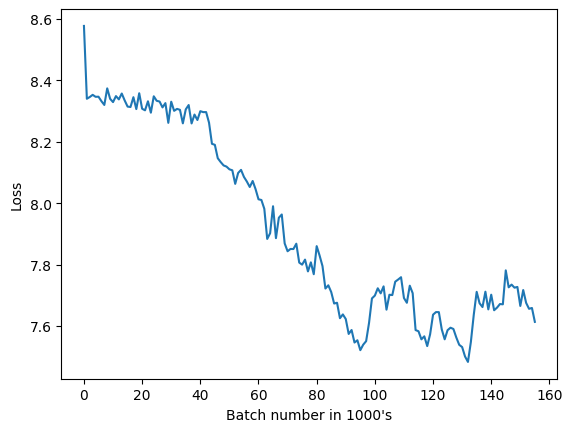

In [31]:
# plot a graph of loss on y axis and batch count on x axis
import matplotlib.pyplot as plt

# compute average each 1000th batch
loss_history_np = np.array(loss_history)
# remove last 59 elements
loss_history_np = loss_history_np[:-59]
loss_history_np = np.mean(loss_history_np.reshape(-1, 1000), axis=1)
# plot only 1000th batch
plt.plot(loss_history_np)
plt.xlabel("Batch number in 1000's")
plt.ylabel("Loss")
plt.show()

In [32]:
# Save the model
model_file_name = "NextItemPredTransformer_3.pt"
torch.save(model, model_file_name)


In [52]:

test_ratings_df= pd.read_pickle(r"lastXRatings.pkl",  compression= 'gzip')

# print the first 5 rows of the dataframe


# drop ratings which are 0s

test_ratings_df = test_ratings_df[test_ratings_df["rating"] != 0]

test_ratings_df.head()

,userId,movieId,rating,timestamp
66,4,1422,1,1042674861
199,7,106489,1,1486253996
154,7,2858,1,1486254186
210,8,318,1,1013444101
215,8,653,1,1013444101


In [53]:
print(len(test_ratings_df["movieId"].unique()))

# print number of unique items in all_movie_ids

print(len(all_movie_ids))

# get missing items in train_ratings_df

missing_items = set(test_ratings_df["movieId"].unique()) - set(all_movie_ids)

# remove the missing items from train_ratings_df

test_ratings_df = test_ratings_df[~test_ratings_df["movieId"].isin(missing_items)]

# print the new number of unique items in train_ratings_df

print(len(test_ratings_df["movieId"].unique()))

# remove all movies which are not in all_movie_ids

test_ratings_df = test_ratings_df[test_ratings_df["movieId"].isin(all_movie_ids)]

# print the new number of unique items in train_ratings_df

print(len(test_ratings_df["movieId"].unique()))

8565
9902
8564
8564


In [54]:
# Combine train_ratings_df and test_ratings_df on userId key

combined_ratings_df = pd.concat([train_ratings_df, test_ratings_df], axis=0)

# remove users which aren't present in train_ratings_df

combined_ratings_df = combined_ratings_df[combined_ratings_df["userId"].isin(train_ratings_df["userId"])]

In [55]:
# print number of unique users in combined_ratings_df

print(len(combined_ratings_df["userId"].unique()))

127878


In [56]:
max_rating_sequence_length = 50

In [57]:
# apply tokenizer_encode_item_ids to the movie ids column
user_id_to_movie_ids_eval = combined_ratings_df.groupby("userId")["movieId"].apply(list).apply(tokenizer.encode_items).to_dict()
user_id_to_rating_times_eval = combined_ratings_df.groupby("userId")["timestamp"].apply(list).to_dict()

# take last 50 ratings for each user
for user_id in user_id_to_movie_ids_eval:
    user_id_to_movie_ids_eval[user_id] = user_id_to_movie_ids_eval[user_id][-max_rating_sequence_length:]
    user_id_to_rating_times_eval[user_id] = user_id_to_rating_times_eval[user_id][-max_rating_sequence_length:]

In [58]:
user_items_vectors_eval = []
user_rating_times_vectors_eval = []
encoded_user_ids_eval = []

for user_id in user_id_to_movie_ids_eval.keys():
    encoded_user_ids_eval.append(tokenizer.encode_user(user_id))
    user_items_vectors_eval.append(np.array(user_id_to_movie_ids_eval[user_id]))
    user_rating_times_vectors_eval.append(np.array(user_id_to_rating_times_eval[user_id]))

In [59]:
from NextItemPredDataset import NextItemPredDataset
from utils import prepare_test_data_for_next_item_pred_transformer
# Create a dataset
dataset = NextItemPredDataset(
    prepare_test_data_for_next_item_pred_transformer(encoded_user_ids_eval, user_items_vectors_eval, user_rating_times_vectors_eval, max_seq_len=max_rating_sequence_length)
)
print(len(encoded_user_ids_eval))

127878


In [60]:
model_file_name = "NextItemPredTransformer_3.pt"


In [61]:
# load the model
trained_model = torch.load(model_file_name)

In [62]:
# Create a dataloader
batch_size = 1
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, num_workers=0
)



 25%|██▍       | 31608/127878 [03:40<11:10, 143.54it/s]


In [63]:
# use cpu 
device = torch.device("cpu")
trained_model.to(device)

NextItemPredTransformer(
  (decoder): ItemDecoder(
    (items_embedding): Embedding(9904, 40)
    (users_embedding): Embedding(127878, 40)
    (time_embedding): Sequential(
      (0): Linear(in_features=52, out_features=2080, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(52, 40))
      (2): ReLU()
    )
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=40, out_features=40, bias=True)
          (key): Linear(in_features=40, out_features=40, bias=False)
          (value): Linear(in_features=40, out_features=40, bias=True)
          (out): Linear(in_features=40, out_features=40, bias=True)
        )
        (attn_ln): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=40, out_features=160, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=160, out_features=40, bias=True)
        )
        (mlp_ln):

In [64]:
import datetime

# convert all titles to numpy array
def map_movie_ids_to_titles(movie_ids, mapping_dict):
    return [mapping_dict[movie_id] for movie_id in movie_ids]
    

In [65]:
# load movies_df.pkl to an object

movies_df= pd.read_pickle(r"movies_df.pkl", compression= 'gzip')

In [66]:
# load top 10 of df
movies_df.head(10)
# get release_date of movieId 1
movies_df[movies_df["movieId"] == 1]["release_date"].values[0]

815011200.0

In [67]:
def get_movie_release_date(movie_id):
    unix_timestamp = movies_df[movies_df["movieId"] == movie_id]["release_date"].values[0]
    # if negative convert to positive
    if unix_timestamp < 0:
        date_time_obj = datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(-3739996800000/1000))
        return date_time_obj.strftime("%d/%m/%Y %H:%M:%S")
    return  datetime.datetime.fromtimestamp(unix_timestamp).strftime("%d/%m/%Y %H:%M:%S")

In [68]:
def check_if_movie_is_in_the_future(prediction_time, movie_id):
    # get release date of movie_id
    release_date = movies_df[movies_df["movieId"] == movie_id]["release_date"].values[0]

    # if release data is negative convert to positive   
    if release_date < 0:
        return False
    # if release data is None, return False
    if release_date is None:
        return False
    # convert both to datetime
    prediction_time_str = datetime.datetime.fromtimestamp(prediction_time)
    try:
        release_date_str = datetime.datetime.fromtimestamp(release_date)
    except:
        return False
    # convert to human readable
    prediction_time_str = datetime.datetime.strptime(prediction_time_str.strftime("%d/%m/%Y %H:%M:%S"), "%d/%m/%Y %H:%M:%S")
    release_date_str = datetime.datetime.strptime(release_date_str.strftime("%d/%m/%Y %H:%M:%S"), "%d/%m/%Y %H:%M:%S")
    if prediction_time < release_date:
        return True
    else:
        return False

In [77]:
# set model to eval mode
trained_model.eval()
results = []
number_of_iterations = 0
hits_at_k = []
true_ranks = []
k = 10
max_number_of_iters = 5000
for batch in dataloader:
        try:
                # Get the inputs; data is a list of [inputs, labels]
                user_ids, items, times, pred_index, true_item_id = batch
                pred_times = torch.gather(times, 1, pred_index.unsqueeze(1))
                # squeeze the pred_times to remove the extra dim
                pred_times = torch.squeeze(pred_times, dim=1)

                # convert to device
                user_ids = user_ids.to(device)
                items = items.to(device)
                times = times.to(device)
                pred_index = pred_index.to(device)
                true_item_id = true_item_id.to(device)
                pred_times = pred_times.to(device)

                # decode items with tokenizer
                # remove batch dim
                items_as_list = torch.squeeze(items, dim=0)
                # convert to list
                items_as_list = items_as_list.tolist()
                # filter out all zeros and 1s
                items_as_list = list(filter(lambda x: x != 0 and x != 1, items_as_list))
                decoded_items = tokenizer.decode_items(items_as_list)
                # decode true_item_id with tokenizer
                decoded_true_item_id = tokenizer.decode_item(true_item_id.item())
                # print titles of the items
                items_in_sequence_titles = map_movie_ids_to_titles(decoded_items, movie_id_to_title)
                # print title of the true item
                true_title = movie_id_to_title[decoded_true_item_id]
                

                # Forward pass
                outputs = trained_model(items, user_ids, times, pred_times)
                relevant_outputs = torch.gather(outputs, 1, pred_index.unsqueeze(1).unsqueeze(2).expand(-1, -1, vocab_size))
                
                # Squeeze dim 1 for relevant_outputs
                relevant_outputs = torch.squeeze(relevant_outputs, dim=1)
                # do a softmax on the outputs
                relevant_outputs = torch.softmax(relevant_outputs, dim=1)
                # remove the batch dim
                relevant_outputs = torch.squeeze(relevant_outputs, dim=0)
                # argsort the relevant outputs and get the places of the true item
                # get the rank of the true item
                argsorted_relevant_outputs = torch.argsort(relevant_outputs, descending=True)
                # get rank of the true item
                true_item_rank = (argsorted_relevant_outputs == true_item_id.item()).nonzero(as_tuple=True)[0].item()
                true_ranks.append(true_item_rank)
                # get the top 10 items and their scores
                top_100_items = torch.topk(relevant_outputs, 100)
                scores, indices = top_100_items
                indices = indices.tolist()
                try:
                        sos_index = indices.index(0)
                except:
                        sos_index = -1
                try:
                        eos_index = indices.index(1)
                except:
                        eos_index = -1
                top_100_item_ids = list(filter(lambda x: x != 0 and x != 1, indices))

                # filter out zeros and 1s

                # remove sos and eos
                # get the top 10 item scores
                top_100_item_scores = scores.tolist()
                # remove indices which are present in items

                # decode the top 10 item ids
                decoded_top_100_item_ids = tokenizer.decode_items(top_100_item_ids)
                decoded_titles = map_movie_ids_to_titles(decoded_top_100_item_ids, movie_id_to_title)
                dt_object = datetime.datetime.fromtimestamp(pred_times.item())

                # add sos and eos to the titles by their index if they exist
                if sos_index != -1:
                        decoded_titles.insert(sos_index, "<sos>")
                if eos_index != -1:
                        decoded_titles.insert(eos_index, "<eos>")
                
                relevant_decoded_items = []
                relevant_scores = []
                relevant_titles = []
                for i in range(len(decoded_top_100_item_ids)):
                        if decoded_top_100_item_ids[i] not in decoded_items and not check_if_movie_is_in_the_future(pred_times.item(), decoded_top_100_item_ids[i]):
                                relevant_decoded_items.append(decoded_top_100_item_ids[i])
                                relevant_scores.append(top_100_item_scores[i])
                                relevant_titles.append(decoded_titles[i])
                
                # take k items and scores
                relevant_decoded_items = relevant_decoded_items[:k]
                # if less than k items continue
                if len(relevant_decoded_items) < k:
                        continue
                release_dates_of_relevant_items = list(map(get_movie_release_date, relevant_decoded_items))
                relevant_titles = relevant_titles[:k]
                relevant_scores = relevant_scores[:k]
                rating_time = dt_object.strftime("%d/%m/%Y %H:%M:%S")
                has_hit = 1 if true_item_id.item() in relevant_decoded_items else 0
                hits_at_k.append(has_hit)
                # get release times of relevant relevant_decoded_items from movies_df


                # print the top 10 items and their scores
                current_map = {
                        "true_title": true_title,
                        "items_in_sequence_titles": items_in_sequence_titles,
                        "top_10_predicted_titles": relevant_titles,
                        "top_10_item_scores": relevant_scores,
                        "release_dates_of_top_10": release_dates_of_relevant_items,
                        "rating_time": rating_time
                }
                results.append(current_map)
                number_of_iterations += 1
                if number_of_iterations % 100 == 0:
                        print(f"Number of iterations: {number_of_iterations}")
                if number_of_iterations > max_number_of_iters:
                        break
        except(Exception) as e:
                print(e)
                continue
  

  4%|▎         | 4795/127878 [11:48<4:47:54,  7.13it/s]  

Number of iterations: 100


  4%|▍         | 4895/127878 [12:02<4:43:18,  7.24it/s]

Number of iterations: 200


  4%|▍         | 4995/127878 [12:17<5:02:14,  6.78it/s]

Number of iterations: 300


  4%|▍         | 5095/127878 [12:31<4:40:15,  7.30it/s]

Number of iterations: 400


  4%|▍         | 5195/127878 [12:46<5:21:51,  6.35it/s]

Number of iterations: 500


  4%|▍         | 5295/127878 [13:01<4:45:22,  7.16it/s]

Number of iterations: 600


  4%|▍         | 5396/127878 [13:15<5:09:49,  6.59it/s]

Number of iterations: 700


  4%|▍         | 5496/127878 [13:31<5:15:00,  6.48it/s]

Number of iterations: 800


  4%|▍         | 5596/127878 [13:46<4:43:28,  7.19it/s]

Number of iterations: 900


  4%|▍         | 5696/127878 [14:00<4:35:58,  7.38it/s]

Number of iterations: 1000


  5%|▍         | 5796/127878 [14:15<4:22:17,  7.76it/s]

Number of iterations: 1100


  5%|▍         | 5896/127878 [14:29<4:49:15,  7.03it/s]

Number of iterations: 1200


  5%|▍         | 5996/127878 [14:43<5:10:21,  6.55it/s]

Number of iterations: 1300


  5%|▍         | 6096/127878 [14:58<5:23:29,  6.27it/s]

Number of iterations: 1400


  5%|▍         | 6196/127878 [15:13<4:33:02,  7.43it/s]

Number of iterations: 1500


  5%|▍         | 6296/127878 [15:27<4:45:49,  7.09it/s]

Number of iterations: 1600


  5%|▌         | 6396/127878 [15:41<4:30:12,  7.49it/s]

Number of iterations: 1700


  5%|▌         | 6496/127878 [15:56<4:49:59,  6.98it/s]

Number of iterations: 1800


  5%|▌         | 6596/127878 [16:11<4:45:58,  7.07it/s]

Number of iterations: 1900


  5%|▌         | 6696/127878 [16:25<4:46:34,  7.05it/s]

Number of iterations: 2000


  5%|▌         | 6796/127878 [16:40<4:51:57,  6.91it/s]

Number of iterations: 2100


  5%|▌         | 6896/127878 [16:55<4:57:18,  6.78it/s]

Number of iterations: 2200


  5%|▌         | 6997/127878 [17:10<4:26:29,  7.56it/s]

Number of iterations: 2300


  6%|▌         | 7096/127878 [17:25<5:18:41,  6.32it/s]

Number of iterations: 2400


  6%|▌         | 7197/127878 [17:40<4:46:09,  7.03it/s]

Number of iterations: 2500


  6%|▌         | 7297/127878 [17:55<4:32:54,  7.36it/s]

Number of iterations: 2600


  6%|▌         | 7397/127878 [18:09<4:24:19,  7.60it/s]

Number of iterations: 2700


  6%|▌         | 7497/127878 [18:23<4:39:07,  7.19it/s]

Number of iterations: 2800


  6%|▌         | 7597/127878 [18:37<4:30:43,  7.41it/s]

Number of iterations: 2900


  6%|▌         | 7697/127878 [18:51<4:40:32,  7.14it/s]

Number of iterations: 3000


  6%|▌         | 7798/127878 [19:06<4:39:32,  7.16it/s]

Number of iterations: 3100


  6%|▌         | 7898/127878 [19:20<4:27:40,  7.47it/s]

Number of iterations: 3200


  6%|▋         | 7998/127878 [19:34<4:51:31,  6.85it/s]

Number of iterations: 3300


  6%|▋         | 8099/127878 [19:49<4:45:59,  6.98it/s]

Number of iterations: 3400


  6%|▋         | 8199/127878 [20:03<4:37:01,  7.20it/s]

Number of iterations: 3500


  6%|▋         | 8299/127878 [20:17<4:31:23,  7.34it/s]

Number of iterations: 3600


  7%|▋         | 8399/127878 [20:31<4:56:24,  6.72it/s]

Number of iterations: 3700


  7%|▋         | 8499/127878 [20:47<5:21:18,  6.19it/s]

Number of iterations: 3800


  7%|▋         | 8599/127878 [21:02<5:43:21,  5.79it/s]

Number of iterations: 3900


  7%|▋         | 8699/127878 [21:17<4:33:14,  7.27it/s]

Number of iterations: 4000


  7%|▋         | 8799/127878 [21:32<4:34:55,  7.22it/s]

Number of iterations: 4100


  7%|▋         | 8899/127878 [21:47<4:43:35,  6.99it/s]

Number of iterations: 4200


  7%|▋         | 8999/127878 [22:01<4:36:26,  7.17it/s]

Number of iterations: 4300


  7%|▋         | 9100/127878 [22:16<4:28:22,  7.38it/s]

Number of iterations: 4400


  7%|▋         | 9201/127878 [22:30<4:21:10,  7.57it/s]

Number of iterations: 4500


  7%|▋         | 9301/127878 [22:44<4:31:37,  7.28it/s]

Number of iterations: 4600


  7%|▋         | 9401/127878 [22:58<4:21:14,  7.56it/s]

Number of iterations: 4700


  7%|▋         | 9501/127878 [23:13<4:41:03,  7.02it/s]

Number of iterations: 4800


  8%|▊         | 9601/127878 [23:28<4:27:54,  7.36it/s]

Number of iterations: 4900


  8%|▊         | 9701/127878 [23:44<4:58:12,  6.60it/s]

Number of iterations: 5000


In [80]:
hits_at_k = np.array(hits_at_k)
number_of_items = vocab_size
mpr = np.mean(np.array(true_ranks) / (number_of_items - 1))

print("Top-K Mean Accuracy: ", np.mean(hits_at_k))
print("MPR: ", np.mean(mpr))
print(hits_at_k)

Top-K Mean Accuracy:  0.001799640071985603
MPR:  0.19856479657792406
[0 0 0 ... 0 0 0]
